In [1]:
import sys
sys.path.append("../scripts")
from timeseries_model import (
 prepare_data, run_arima, run_lstm, evaluate_performance,forecast_future_lstm
)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
full_df = pd.read_csv("../data/processed/market_data_processed.csv", parse_dates=["Date"])

In [4]:
train_tsla, test_tsla = prepare_data(full_df, asset_name='TSLA')

print(f"Training set size: {len(train_tsla)}")
print(f"Testing set size: {len(test_tsla)}")

Training set size: 2516
Testing set size: 259


2. Run ARIMA Model

In [5]:
arima_forecast, arima_order = run_arima(train_tsla, test_tsla)
print(f"Optimal ARIMA Order: {arima_order}")

# Evaluate ARIMA
arima_metrics = evaluate_performance(test_tsla, arima_forecast)
print("ARIMA Performance:", arima_metrics)

c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure

Optimal ARIMA Order: (0, 1, 0)
ARIMA Performance: {'MAE': 69.4989569233191, 'RMSE': np.float64(82.93461282588196), 'MAPE': np.float64(22.557915255182202)}


c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a suppo

3. Run LSTM Model

In [6]:
# Note: This might take a minute depending on your GPU/CPU
lstm_forecast, my_lstm_model, my_scaler= run_lstm(train_tsla, test_tsla, window_size=60)

# Evaluate LSTM
lstm_metrics = evaluate_performance(test_tsla, lstm_forecast)
print("LSTM Performance:", lstm_metrics)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
LSTM Performance: {'MAE': 20.348399512095803, 'RMSE': np.float64(24.588418403451907), 'MAPE': np.float64(5.573373401856766)}


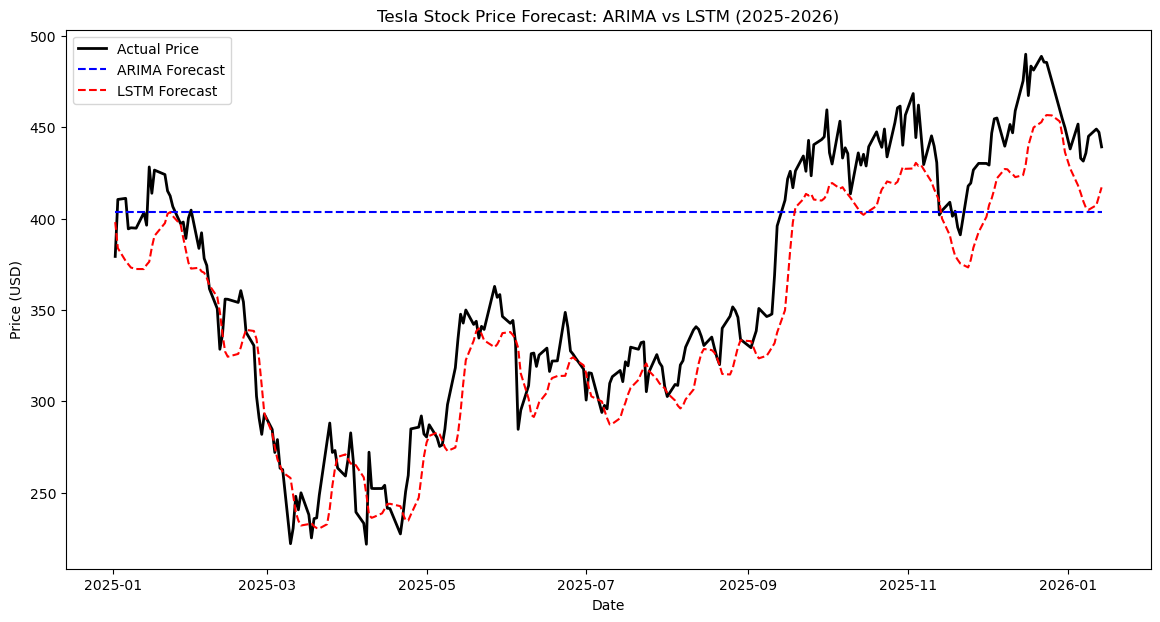

In [7]:


plt.figure(figsize=(14, 7))
plt.plot(test_tsla.index, test_tsla.values, label='Actual Price', color='black', lw=2)
plt.plot(test_tsla.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')
plt.plot(test_tsla.index, lstm_forecast, label='LSTM Forecast', color='red', linestyle='--')

plt.title('Tesla Stock Price Forecast: ARIMA vs LSTM (2025-2026)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [9]:
def generate_recursive_forecast(model, scaler, current_window, steps=126):
    """Generates future predictions by feeding output back as input."""
    future_predictions = []
    # Ensure window is in the correct shape (1, 60, 1)
    last_window = current_window.reshape((1, 60, 1))

    for _ in range(steps):
        # Predict 1 step ahead
        pred = model.predict(last_window, verbose=0)
        future_predictions.append(pred[0])
        
        # Update window: Slide left and add the new prediction to the end
        pred_reshaped = pred.reshape((1, 1, 1))
        last_window = np.append(last_window[:, 1:, :], pred_reshaped, axis=1)

    # Convert scaled values back to USD
    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))



In [10]:
# Get the last 60 days of the test set to start the future forecast
last_60_days_scaled = my_scaler.transform(test_tsla[-60:])
future_tsla_prices = generate_recursive_forecast(my_lstm_model, my_scaler, last_60_days_scaled)

print(f"Generated {len(future_tsla_prices)} days of future forecast.")

Generated 126 days of future forecast.


In [11]:
future_tsla_prices

array([[419.139  ],
       [414.91907],
       [407.5376 ],
       [398.43192],
       [388.49875],
       [378.30417],
       [368.207  ],
       [358.43387],
       [349.12408],
       [340.35782],
       [332.17303],
       [324.57852],
       [317.5616 ],
       [311.09497],
       [305.14194],
       [299.6598 ],
       [294.60345],
       [289.92755],
       [285.58817],
       [281.544  ],
       [277.75717],
       [274.1939 ],
       [270.82437],
       [267.6226 ],
       [264.56665],
       [261.63803],
       [258.8215 ],
       [256.1045 ],
       [253.4769 ],
       [250.93065],
       [248.4593 ],
       [246.0578 ],
       [243.7222 ],
       [241.44925],
       [239.23634],
       [237.0815 ],
       [234.98271],
       [232.93843],
       [230.94722],
       [229.00769],
       [227.11826],
       [225.27776],
       [223.4847 ],
       [221.73764],
       [220.0352 ],
       [218.37595],
       [216.75836],
       [215.18118],
       [213.64282],
       [212.14192],


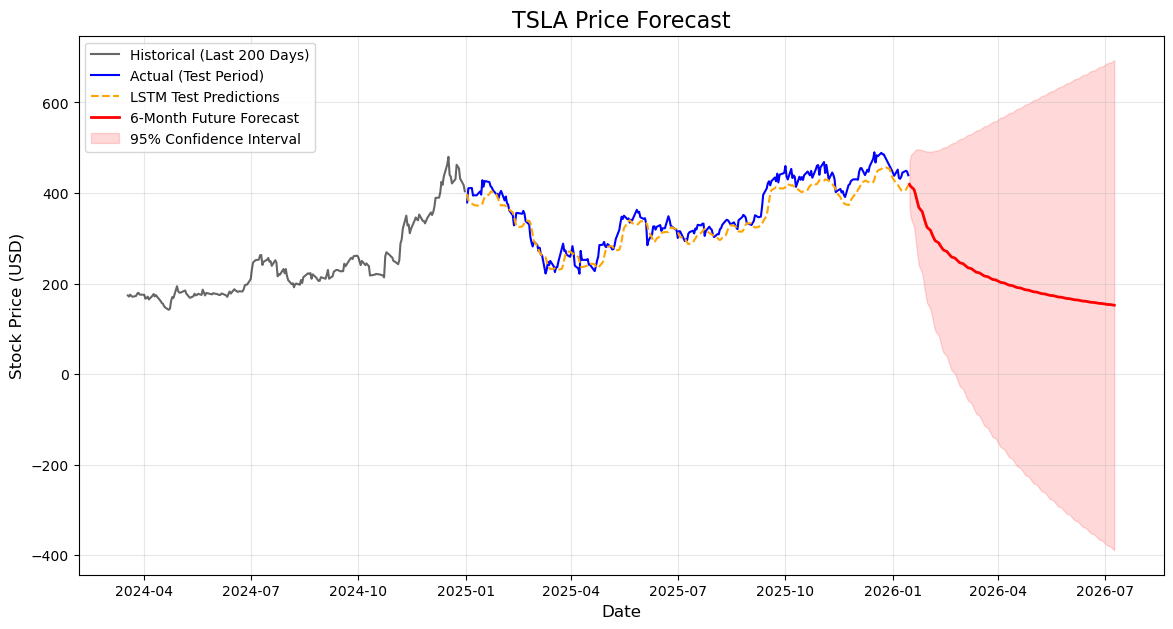

In [12]:
def plot_final_forecast(train, test, test_preds, future_preds, title="TSLA Price Forecast"):
    plt.figure(figsize=(14, 7))
    
    # 1. Plot Historical Training Data
    plt.plot(train.index[-200:], train.values[-200:], label="Historical (Last 200 Days)", color='black', alpha=0.6)
    
    # 2. Plot Test Period (Actual vs Predicted)
    plt.plot(test.index, test.values, label="Actual (Test Period)", color='blue')
    plt.plot(test.index, test_preds, label="LSTM Test Predictions", color='orange', linestyle='--')
    
    # 3. Plot Future Forecast
    # Create a date index for the future (starting the day after test ends)
    future_dates = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=len(future_preds), freq='B')
    plt.plot(future_dates, future_preds, label="6-Month Future Forecast", color='red', linewidth=2)
    
    # 4. Add Confidence Intervals (Uncertainty Fan)
    # Estimate uncertainty based on the RMSE of your test predictions
    test_rmse = np.sqrt(np.mean((test.values.flatten() - test_preds.flatten())**2))
    
    # The uncertainty grows over time (square root of time rule)
    uncertainty = [test_rmse * np.sqrt(i+1) for i in range(len(future_preds))]
    lower_bound = future_preds.flatten() - (1.96 * np.array(uncertainty))
    upper_bound = future_preds.flatten() + (1.96 * np.array(uncertainty))
    
    plt.fill_between(future_dates, lower_bound, upper_bound, color='red', alpha=0.15, label="95% Confidence Interval")

    # Formatting
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Stock Price (USD)", fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()

# Execution
# Note: Ensure future_tsla_prices is from Task 3.1
plot_final_forecast(train_tsla, test_tsla, lstm_forecast, future_tsla_prices)